

# Brainstorm Elekta phantom dataset tutorial

Here we compute the evoked from raw for the Brainstorm Elekta phantom
tutorial dataset. For comparison, see :footcite:`TadelEtAl2011` and
[the original Brainstorm tutorial](https://neuroimage.usc.edu/brainstorm/Tutorials/PhantomElekta)_.


In [1]:
%matplotlib qt
%load_ext autoreload
%autoreload 2

import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import find_events, fit_dipole
from mne.datasets import fetch_phantom
from mne.datasets.brainstorm import bst_phantom_elekta
from mne.io import read_raw_fif

print(__doc__)

Automatically created module for IPython interactive environment


The data were collected with an Elekta Neuromag VectorView system at 1000 Hz
and low-pass filtered at 330 Hz. Here the medium-amplitude (200 nAm) data
are read to construct instances of :class:`mne.io.Raw`.



In [2]:
data_path = bst_phantom_elekta.data_path(verbose=True)

raw_fname = op.join(data_path, 'kojak_all_200nAm_pp_no_chpi_no_ms_raw.fif')
raw = read_raw_fif(raw_fname)

Opening raw data file C:\Users\lukas\mne_data\MNE-brainstorm-data\bst_phantom_elekta\kojak_all_200nAm_pp_no_chpi_no_ms_raw.fif...
    Read a total of 13 projection items:
        planar-0.0-115.0-PCA-01 (1 x 306)  idle
        planar-0.0-115.0-PCA-02 (1 x 306)  idle
        planar-0.0-115.0-PCA-03 (1 x 306)  idle
        planar-0.0-115.0-PCA-04 (1 x 306)  idle
        planar-0.0-115.0-PCA-05 (1 x 306)  idle
        axial-0.0-115.0-PCA-01 (1 x 306)  idle
        axial-0.0-115.0-PCA-02 (1 x 306)  idle
        axial-0.0-115.0-PCA-03 (1 x 306)  idle
        axial-0.0-115.0-PCA-04 (1 x 306)  idle
        axial-0.0-115.0-PCA-05 (1 x 306)  idle
        axial-0.0-115.0-PCA-06 (1 x 306)  idle
        axial-0.0-115.0-PCA-07 (1 x 306)  idle
        axial-0.0-115.0-PCA-08 (1 x 306)  idle
    Range : 47000 ... 437999 =     47.000 ...   437.999 secs
Ready.


Data channel array consisted of 204 MEG planor gradiometers,
102 axial magnetometers, and 3 stimulus channels. Let's get the events
for the phantom, where each dipole (1-32) gets its own event:



In [3]:
events = find_events(raw, 'STI201')
raw.plot(events=events)
raw.info['bads'] = ['MEG1933', 'MEG2421']

645 events found
Event IDs: [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32  256  768 1792 3840 7936]
Using matplotlib as 2D backend.
Opening raw-browser...


The data have strong line frequency (60 Hz and harmonics) and cHPI coil
noise (five peaks around 300 Hz). Here we plot only out to 60 seconds
to save memory:



Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


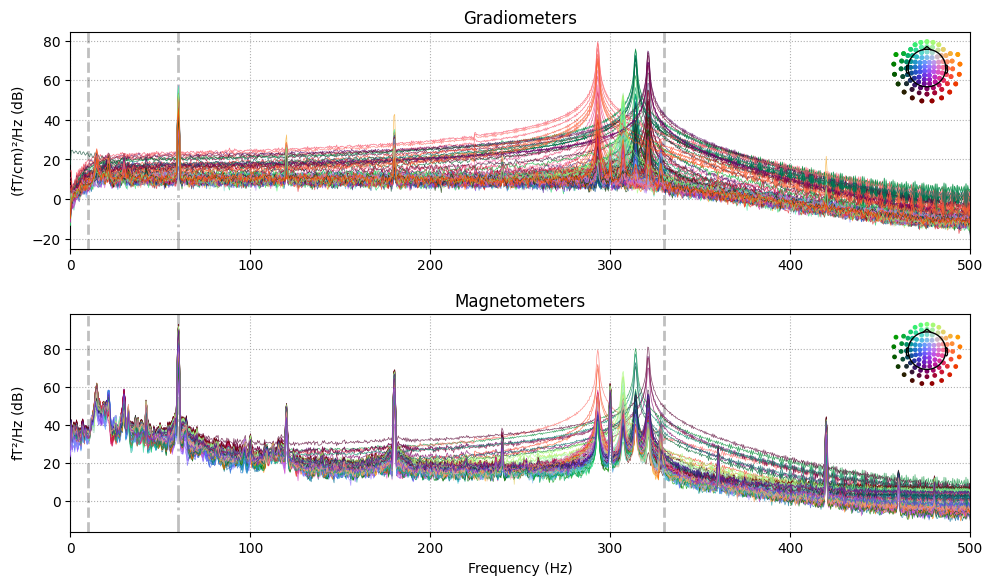

In [4]:
raw.plot_psd(tmax=30., average=False)

Our phantom produces sinusoidal bursts at 20 Hz:



Opening raw-browser...


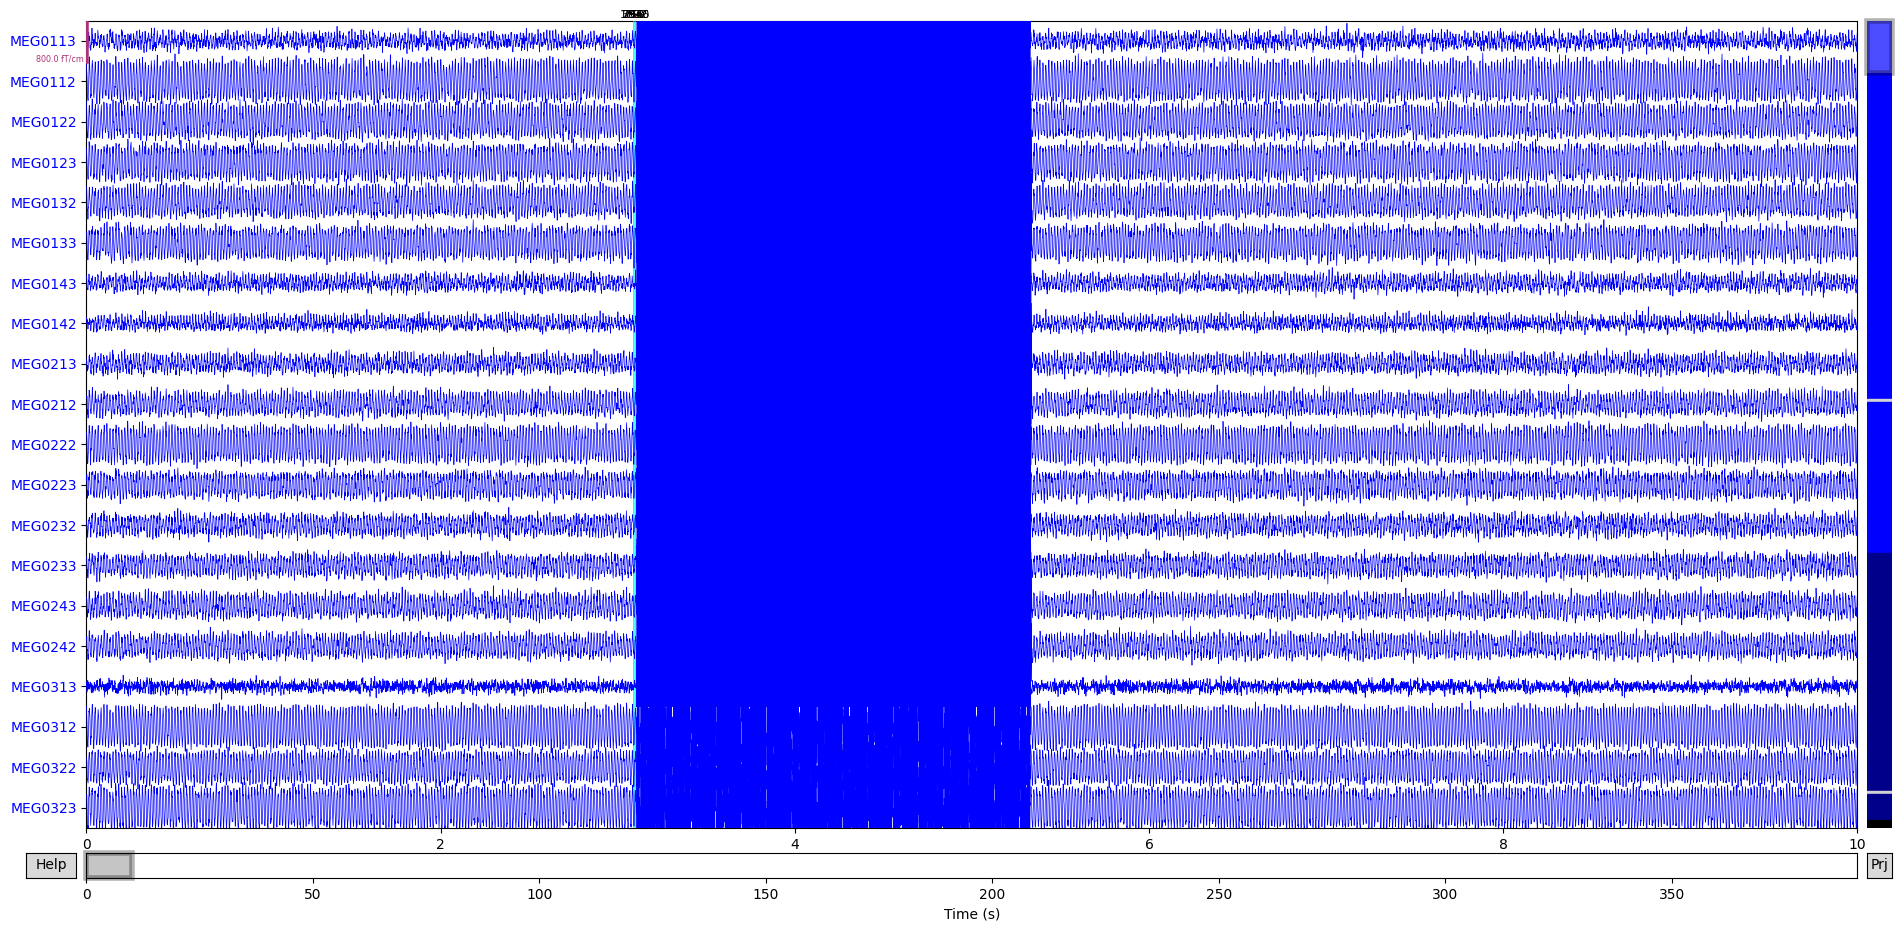

In [5]:
raw.plot(events=events)

Now we epoch our data, average it, and look at the first dipole response.
The first peak appears around 3 ms. Because we low-passed at 40 Hz,
we can also decimate our data to save memory.



Not setting metadata
640 matching events found
Setting baseline interval to [-0.1, -0.05] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 13)
13 projection items activated


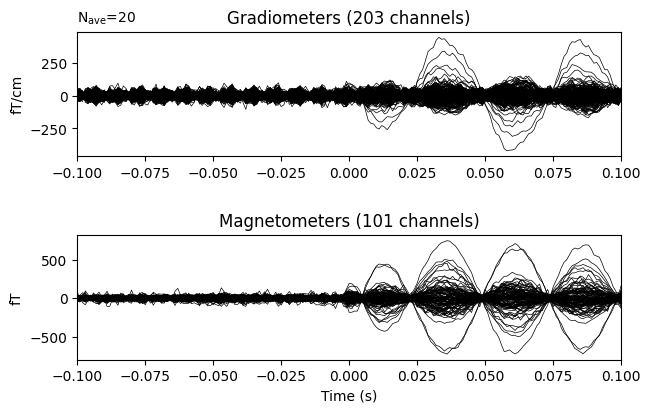

In [6]:
tmin, tmax = -0.1, 0.1
bmax = -0.05  # Avoid capture filter ringing into baseline
event_id = list(range(1, 33))
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=(None, bmax),
                    preload=False)
epochs['1'].average().plot(time_unit='s')


Let's use a `sphere head geometry model <eeg_sphere_model>`
and let's see the coordinate alignment and the sphere location. The phantom
is properly modeled by a single-shell sphere with origin (0., 0., 0.).

Even though this is a VectorView/TRIUX phantom, we can use the Otaniemi
phantom subject as a surrogate because the "head" surface (hemisphere outer
shell) has the same geometry for both phantoms, even though the internal
dipole locations differ. The phantom_otaniemi scan was aligned to the
phantom's head coordinate frame, so an identity ``trans`` is appropriate
here.



In [7]:
subjects_dir = data_path
fetch_phantom('otaniemi', subjects_dir=subjects_dir)
sphere = mne.make_sphere_model(r0=(0., 0., 0.), head_radius=0.08)
subject = 'phantom_otaniemi'
trans = mne.transforms.Transform('head', 'mri', np.eye(4))
mne.viz.plot_alignment(
    epochs.info, subject=subject, show_axes=True, bem=sphere, dig=True,
    surfaces=('head-dense', 'inner_skull'), trans=trans, mri_fiducials=True,
    subjects_dir=subjects_dir)

0 files missing from phantom_otaniemi.txt in C:\Users\lukas\mne_data\MNE-brainstorm-data\bst_phantom_elekta

Equiv. model fitting -> RV = 0.00366452 %
mu1 = 0.944069    lambda1 = 0.138768
mu2 = 0.665867    lambda2 = 0.684541
mu3 = -0.129568    lambda3 = -0.0129386
Set up EEG sphere model with scalp radius    80.0 mm

Using pyvistaqt 3d backend.

Using lh.seghead for head surface.
Getting helmet for system 306m
Channel types::	grad: 203, mag: 101


Let's do some dipole fits. We first compute the noise covariance,
then do the fits for each event_id taking the time instant that maximizes
the global field power.



In [8]:
# here we can get away with using method='oas' for speed (faster than "shrunk")
# but in general "shrunk" is usually better
cov = mne.compute_covariance(epochs, tmax=bmax)
mne.viz.plot_evoked_white(epochs['1'].average(), cov)

data = []
t_peak = 0.036  # true for Elekta phantom
for ii in event_id:
    # Avoid the first and last trials -- can contain dipole-switching artifacts
    evoked = epochs[str(ii)][1:-1].average().crop(t_peak, t_peak)
    data.append(evoked.data[:, 0])
evoked = mne.EvokedArray(np.array(data).T, evoked.info, tmin=0.)
del epochs
dip, residual = fit_dipole(evoked, cov, sphere, n_jobs=1)

Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events and 201 original time points ...
0 bad epochs dropped
Loading data for 20 events a

Do a quick visualization of how much variance we explained, putting the
data and residuals on the same scale (here the "time points" are the
32 dipole peak values that we fit):



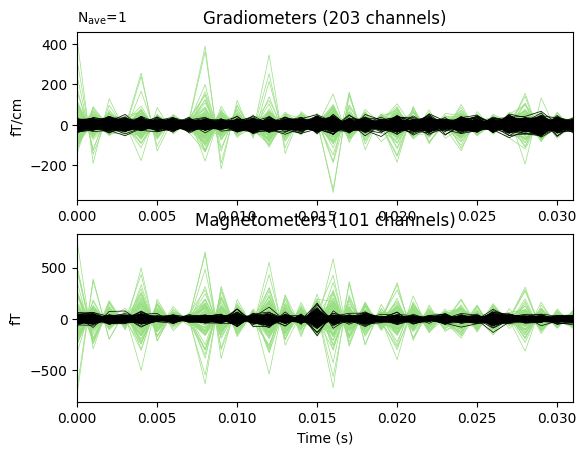

In [9]:
fig, axes = plt.subplots(2, 1)
evoked.plot(axes=axes)
for ax in axes:
    for text in list(ax.texts):
        text.remove()
    for line in ax.lines:
        line.set_color('#98df81')
residual.plot(axes=axes)

Now we can compare to the actual locations, taking the difference in mm:



In [10]:
actual_pos, actual_ori = mne.dipole.get_phantom_dipoles()
actual_amp = 100.  # nAm

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 7))

diffs = 1000 * np.sqrt(np.sum((dip.pos - actual_pos) ** 2, axis=-1))
print('mean(position error) = %0.1f mm' % (np.mean(diffs),))
ax1.bar(event_id, diffs)
ax1.set_xlabel('Dipole index')
ax1.set_ylabel('Loc. error (mm)')

angles = np.rad2deg(np.arccos(np.abs(np.sum(dip.ori * actual_ori, axis=1))))
print(u'mean(angle error) = %0.1f°' % (np.mean(angles),))
ax2.bar(event_id, angles)
ax2.set_xlabel('Dipole index')
ax2.set_ylabel(u'Angle error (°)')

amps = actual_amp - dip.amplitude / 1e-9
print('mean(abs amplitude error) = %0.1f nAm' % (np.mean(np.abs(amps)),))
ax3.bar(event_id, amps)
ax3.set_xlabel('Dipole index')
ax3.set_ylabel('Amplitude error (nAm)')

fig.tight_layout()
plt.show()

mean(position error) = 2.6 mm
mean(angle error) = 2.4°
mean(abs amplitude error) = 16.9 nAm


Let's plot the positions and the orientations of the actual and the estimated
dipoles



In [11]:
actual_amp = np.ones(len(dip))  # misc amp to create Dipole instance
actual_gof = np.ones(len(dip))  # misc GOF to create Dipole instance
dip_true = \
    mne.Dipole(dip.times, actual_pos, actual_amp, actual_ori, actual_gof)

fig = mne.viz.plot_alignment(
    evoked.info, trans, subject, bem=sphere, surfaces={'head-dense': 0.2},
    coord_frame='head', meg='helmet', show_axes=True,
    subjects_dir=subjects_dir)

# Plot the position and the orientation of the actual dipole
fig = mne.viz.plot_dipole_locations(dipoles=dip_true, mode='arrow',
                                    subject=subject, color=(0., 0., 0.),
                                    fig=fig)

# Plot the position and the orientation of the estimated dipole
fig = mne.viz.plot_dipole_locations(dipoles=dip, mode='arrow', subject=subject,
                                    color=(0.2, 1., 0.5), fig=fig)

mne.viz.set_3d_view(figure=fig, azimuth=70, elevation=80, distance=0.5)

Using lh.seghead for head surface.
Getting helmet for system 306m


# Create Forward Model

In [23]:
mne.setup_source_space(subject, spacing="oct6")


OSError: Could not find the LH surface C:\Users\lukas\mne_data\MNE-sample-data\subjects\phantom_otaniemi\surf\lh.white

In [20]:
vol_src = mne.setup_volume_source_space(
    subject, subjects_dir=subjects_dir, sphere=sphere, pos=25, sphere_units='m', verbose=0)  # just for speed!

fwd = mne.make_forward_solution(raw_fname, trans=trans, src=vol_src, bem=sphere,
                                meg=True, eeg=False, mindist=5.0, n_jobs=1,
                                verbose=0)
print(vol_src,fwd)

<SourceSpaces: [<volume, shape=(7, 7, 7), n_used=81>] MRI (surface RAS) coords, subject 'phantom_otaniemi', ~64.1 MB> <Forward | MEG channels: 306 | EEG channels: 0 | Source space: Volume with 81 grid points | Source orientation: Free>


In [25]:
from mne.datasets.brainstorm import bst_phantom_ctf
data_path = bst_phantom_ctf.data_path(verbose=True)


100%|#############################################| 86.8M/86.8M [00:00<?, ?B/s]
Untarring contents of 'C:\Users\lukas\mne_data\bst_phantom_ctf.tar.gz' to 'C:\Users\lukas\mne_data\MNE-brainstorm-data'


# Train Net

In [21]:
# evoked
import sys; sys.path.insert(0, '../')
from esinet import Simulation, Net
settings = dict(duration_of_trial=0.)
sim = Simulation(fwd, evoked.info, settings=settings).simulate(2)
# net = Net(fwd, model_type="lstm")
# net.fit(sim, epochs=10)
# stc = net.predict(evoked)

Forward model does not contain fixed orientations - expect unexpected behavior!
Simulating data based on sparse patches.


  0%|          | 0/2 [00:00<?, ?it/s]

Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed ori

  0%|          | 0/2 [00:02<?, ?it/s]


Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed orientations - expect unexpected behavior!
Forward model does not contain fixed or

IndexError: index 341 is out of bounds for axis 0 with size 81

In [ ]:
fwd

Good channels,"204 Gradiometers, 102 Magnetometers"
Bad channels,None
Source space,Volume with 1237 grid points
Source orientation,Free


In [ ]:
source = fwd["src"]
subject_his_id = source[0]['subject_his_id']

pos_left = mne.vertex_to_mni(source[0]['vertno'], 0, subject_his_id, verbose=0)

FileNotFoundError: File does not exist: C:\Users\lukas\mne_data\MNE-sample-data\subjects\phantom_otaniemi\surf\lh.white

In [ ]:
plt.figure()
plt.imshow(source[0]["rr"], aspect=1/4000)

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*source[0]["rr"].T, color="red")
ax.scatter(*source[1]["rr"].T, color="blue")

IndexError: list index out of range

In [ ]:
source[0]["rr"].shape

(4913, 3)